# Transformers with Pytorch Tutorial

## Imports

In [59]:
import torch
print(torch.cuda.is_available())


False


In [60]:
import torch.nn as nn
import math
import torch.nn.functional as F

## The building blocks of transformer models

In [61]:
# Define the transformer model
model = nn.Transformer(
    d_model=512,
    nhead=8, 
    num_encoder_layers = 6,
    num_decoder_layers = 6,
)

# Print the model object
print(model)

Transformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, o

/opt/anaconda3/envs/sheeba/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


### Create the embedding layer

In [105]:
class InputEmbeddings(nn.Module):
    def __init__(self, vocab_size: int, d_model: int)-> None:
        super().__init__()
        self.d_model = d_model # emb dimensions
        self.vocab_size = vocab_size 
        self.embedding = nn.Embedding(vocab_size, d_model) # The embedding layer

    def forward(self, x):
        # Standard practice - scaling by square root of model dim to avoid token and positional embeddings to overwhlem each other. 
        return self.embedding(x) * math.sqrt(self.d_model) 

In [106]:
embedding_layer = InputEmbeddings(vocab_size=10000, d_model=512)

In [107]:
embedded_output = embedding_layer(torch.tensor([[1,2,3,4],[5,6,7,8]])) # 2 batches of 4 token ids sequences each
embedded_output.shape # right dimensionality of the embedded sequence

torch.Size([2, 4, 512])

In [108]:
embedded_output[0][0][:10]

tensor([  9.4695,  54.8216, -47.8387, -26.3964,  -8.6042, -20.4541, -23.7473,
          4.6616,   3.2406,  -2.5655], grad_fn=<SliceBackward0>)

### Add the Positional encoding

Positional encoding - encodes each token's position in the sequence into a positional embedding, and addes them into the token embeddings to capture positional information. 

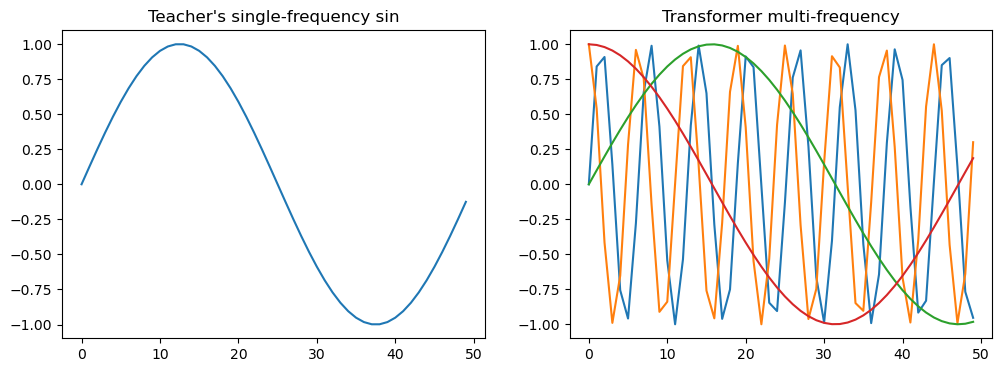

In [145]:
import torch, math
import matplotlib.pyplot as plt

max_seq_length = 50
d_model = 8

# Teacher's formula
pos = torch.arange(max_seq_length).unsqueeze(1)
teacher_enc = torch.sin(2 * math.pi * pos / max_seq_length)

# Transformer formula
position = torch.arange(max_seq_length, dtype=torch.float).unsqueeze(1)
div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * -(math.log(10000.0) / d_model))
pe = torch.zeros(max_seq_length, d_model)
pe[:, 0::2] = torch.sin(position * div_term)
pe[:, 1::2] = torch.cos(position * div_term)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Teacher's single-frequency sin")
plt.plot(pos, teacher_enc)
plt.subplot(1, 2, 2)
plt.title("Transformer multi-frequency")
plt.plot(pe[:, :4])  # first 4 dims
plt.show()


In [146]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()
        # initialize the positional embeddings, pe, to zeros matrix shaped max_length, dim
        pe = torch.zeros(max_seq_length, d_model) 
        # create a tensor of positions for each token in the sequence, 
        # which we'll transform using unsqueeze so it can be used in positional encoding calculations.
        # In PyTorch, unsqueeze is used to add a dimension of size 1 to a tensor at a specified position (axis).
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1) 

        #  = tensor([[0.],[1.],[2.],[3.]])
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * -(math.log(10000.0)/ d_model))

        # Perform the sine and cosine calculations
        # sin is applied to even vector values
        pe[:, 0::2] = torch.sin(position * div_term)
        # cos is applied to odd vector values
        pe[:, 1::2] = torch.cos(position * div_term)

        # register_buffer stores pe (with additional batch dimension) without making it a learnable parameter during training
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self,x):
        # add the positional embeddings to the input token embeddings, x
        return x + self.pe[:, :x.size(1)]

In [110]:
torch.arange(0, 4, dtype=torch.float).unsqueeze(1)

tensor([[0.],
        [1.],
        [2.],
        [3.]])

In [111]:
torch.zeros(4, 512)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [112]:
pos_encoding_layer = PositionalEncoding(d_model=512, max_seq_length=4)
pos_encoded_output = pos_encoding_layer(embedded_output)
print(pos_encoded_output.shape)
print(pos_encoded_output[0][0][:10])

torch.Size([2, 4, 512])
tensor([  9.4695,  55.8216, -47.8387, -25.3964,  -8.6042, -19.4541, -23.7473,
          5.6616,   3.2406,  -1.5655], grad_fn=<SliceBackward0>)


### Self-attention

In [142]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_head."
        self.num_heads = num_heads # nu. of attention heads
        self.d_model = d_model
        self.head_dim = d_model // num_heads # head_dim is the embedding dimensions each head will process.
        # bias=False: no impact on performance while reducing complexity (only for inputs)
        self.query_linear = nn.Linear(d_model, d_model, bias=False)  # W_Q
        self.key_linear   = nn.Linear(d_model, d_model, bias=False)  # W_K
        self.value_linear = nn.Linear(d_model, d_model, bias=False)  # W_V
        self.output_linear = nn.Linear(d_model, d_model) 

    def split_heads(self, x, batch_size):
        '''splits the query, key, and values tensors 
        between the heads and transforms them into shape: 
        batch_size, num_heads, seq_length, head_dim.'''
        seq_length = x.size(1)
        x = x.reshape(batch_size, seq_length, self.num_heads, self.head_dim)
        return x.permute(0,2,1,3) 

    def compute_attention(self, query, key, value, mask=None):
        '''torch.matmul calculates the dot product between the query and key matrices, 
        which requires transposing the key matrix, 
        and calculates the attention weights inside each head using softmax.'''
        # query <batch, n_heads, n_seq, head_dim>
        # key.transpose(-2,-1) <batch, n_heads, head_dim, n_seq>
        # scores  <batch, n_heads, n_seq, n_seq> = attention weights between every pair of tokens for each head.
        scores = torch.matmul(query, key.transpose(-2,-1)) / (self.head_dim ** 0.5)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attention_weights = F.softmax(scores, dim=-1) # keeps scores dim
        # weighted sum of value vectors based on how much attention each query pays to each key,
        # in parallel for every head and every batch.
        return torch.matmul(attention_weights, value) #  <batch, n_heads, n_seq, head_dim>

    def combine_heads(self, x, batch_size): 
        '''transforms the attention weights back into the original embedding shape.'''
        x = x.permute(0,2,1,3).contiguous()   # <batch,n_seq, n_heads, head_dim>
        return x.view(batch_size, -1, self.d_model)   # <batch, n_seq, d_model>

    def forward(self, query, key, value, mask=None):
        '''In the forward method, we split the query, key, and value tensors across the heads 
        and compute the attention weights. The weights are combined and passed through 
        the output layer to obtain the updated token embeddings projected into the original dimensionality.'''
        batch_size = query.size(0)

        # apply the attention weights on input to generate Q,K,V, and split them between the heads
        query = self.split_heads(self.query_linear(query), batch_size) # Q=X*W_Q
        key = self.split_heads(self.key_linear(key), batch_size) # K=X*W_K
        value = self.split_heads(self.value_linear(value), batch_size) # V=X*W_V

        attention_weights = self.compute_attention(query, key, value, mask)
        
        output = self.combine_heads(attention_weights, batch_size)
        return self.output_linear(output) # concatenate and project head outputs


In [114]:
# # Define attention parameters
# d_model = 512
# num_heads = 8

# # Instantiate a MultiHeadAttention instance
# multihead_attn = MultiHeadAttention(d_model, num_heads)

# # Pass the query, key, and value matrices through the mechanism
# output = multihead_attn(query, key, value)
# print(output.shape)

## Building Transformer Architectures

### Encoder Transformer

In [115]:
class FeedForwardSubLayer(nn.Module):
    '''
    Our FeedForwardSublayer class contains two fully connected linear layers separated by a ReLU activation.
    This is a position-wise feedforward network — it processes each position in the sequence independently 
    (same weights applied across all positions).
    expanding each token's representation into a higher-dimensional space (d_ff) to capture richer patterns, 
    then projecting it back to d_model.
    '''
    def __init__(self, d_model, d_ff):
        super().__init__()
        # we use a dimension d_ff between linear layers, to further facilitate capturing complex patterns.
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        # applies the forward pass to the attention mechanism outputs, passing them through the layers.
        return self.fc2(self.relu(self.fc1(x)))


In [116]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.ff_sublayer = FeedForwardSubLayer(d_model, d_ff)
        # layer normalizations for keeping the scales and variances of 
        # input embeddings consistent before and after the feed forward layer.
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        # Dropouts are also used to regularize and stabilize training.
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, src_mask):
        '''the input embeddings are passed as the query, key, and value matrices, 
        and a mask is used to prevent the processing of padding tokens in the input sequence.'''
        attn_output = self.self_attn(x, x, x, src_mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.ff_sublayer(x)
        x = self.norm2(x + self.dropout(ff_output))
        
        return x

In [117]:
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_seq_length):
        super().__init__()
        self.embedding = InputEmbeddings(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)
        self.layers = nn.ModuleList(
            [EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)]
        )

    def forward(self, x, src_mask):
        '''embeds the inputs, performs positional encoding, 
        and iterates through the encoder layers, applying the padding mask.'''
        x = self.embedding(x)
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x, src_mask)
        return x
        

In [118]:
class ClassifierHead(nn.Module):
    '''Tasks: text classification, sentiment analysis, NER, extractive QA, etc.
    fc: fully connected linear layer - transforms encoder hidden states into num_classes class probabilites.
    '''
    def __init__(self, d_model, nun_classes):
        super().__init__()
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        logits = self.fc(x)
        return F.log_softmax(logits, dim=-1)

In [119]:
class RegressionHead(nn.Module):
    '''A regression head has a linear layer with an output dimension equal to the number of target regression outputs. 
    Tasks: estimate text readability, language complexity, etc.
    output_dim is 1 when predicting a single numerical value'''
    def __init__(self, d_model, output_dim):
        super().__init__()
        self.fc = nn.Linear(d_model, output_dim)

    def forward(self, x):
        return self.fc(x)

In [120]:
# USAGE EXAMPLE
vocab_size = 10000
d_model = 512
num_layers= 6
num_heads= 8
d_ff= 2048
dropout= 0.1
seq_length= 4
num_classes = 10  # e.g., classification task with 10 labels

# Instantiate the encoder transformer's body and head
encoder = TransformerEncoder(vocab_size, d_model, num_layers, num_heads, d_ff, dropout, seq_length)
classifier = ClassifierHead(d_model, num_classes)

input_sequence = torch.tensor([
    [1, 2, 3, 4],
    [5, 6, 7, 8]
], dtype=torch.long)
# For simplicity, no masking applied here
src_mask = None

# Complete the forward pass 
output = encoder(input_sequence, src_mask) # shape: [2, 4, 512]
classification = classifier(output)        # shape: [2, 10]

print(f"Classification outputs for a batch of {seq_length} sequences:\n{classification}")
print(f"Encoder output shape: {output.shape}\nClassification head output shape: {classification.shape}")

Classification outputs for a batch of 4 sequences:
tensor([[[-2.3901, -2.6926, -2.8686, -2.3044, -2.5401, -1.1451, -3.3319,
          -1.9069, -2.6089, -3.5356],
         [-2.5802, -1.9578, -3.2475, -2.1674, -3.3087, -1.8631, -2.4466,
          -2.0474, -1.9959, -2.4483],
         [-2.0974, -2.8207, -3.3400, -3.0294, -3.4434, -1.5044, -2.9731,
          -2.1558, -1.4135, -2.6657],
         [-2.0082, -2.5286, -2.5382, -3.2403, -2.3510, -1.7922, -2.9124,
          -2.3266, -1.7091, -2.6179]],

        [[-2.9532, -2.5957, -3.2623, -2.3278, -2.1671, -2.3606, -2.3577,
          -2.1535, -1.3048, -3.0662],
         [-2.3064, -2.6154, -3.0634, -2.1456, -2.3987, -1.9979, -2.8601,
          -2.4897, -1.6556, -2.2456],
         [-2.5417, -2.0297, -3.4282, -1.9043, -2.9392, -1.9738, -1.8172,
          -3.4897, -1.8905, -2.6215],
         [-2.0682, -2.2871, -3.0988, -2.1068, -2.7996, -3.1513, -1.9047,
          -2.7856, -1.4737, -2.7798]]], grad_fn=<LogSoftmaxBackward0>)
Encoder output shape: torc

### Decoder Transformer

Creating causal attention mask with 0's above diagonal, to avoid attention with prior tokens:

In [121]:
tgt_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()

In [122]:
tgt_mask

tensor([[[ True, False, False, False],
         [ True,  True, False, False],
         [ True,  True,  True, False],
         [ True,  True,  True,  True]]])

In [123]:
class DecoderLayer(nn.Module):
    '''The decoder layer is the same as the encoder layer we created before: 
    multi-head attention followed by a feed-forward sublayer with layer normalizations and dropouts before and after. 
    The only difference is the padding mask has been replaced with the causal attention mask in the forward pass.'''
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.ff_sublayer = FeedForwardSubLayer(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.ff_sublayer(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [124]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_seq_length):
        super(TransformerDecoder, self).__init__()
        self.embedding = InputEmbeddings(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)
        self.layers = nn.ModuleList(
            [DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)]
        )
        # Adding head inside the transformer body class - now resulting in 
        # vocab_size last layer since er predict next token and not categorical/numerical target
        self.fc = nn.Linear(d_model, vocab_size) 

    def forward(self, x, tgt_mask):
        '''embeds the inputs, performs positional encoding, 
        and iterates through the encoder layers, applying the padding mask.'''
        x = self.embedding(x)
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x, tgt_mask) # different mask
        # We add a final linear layer with output size equal to the vocabulary size, 
        x = self.fc(x)
        # and softmax activation to the forward method, to project hidden states into word likelihoods.
        return F.log_softmax(x,dim=-1)
        

In [125]:
decoder = TransformerDecoder(vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_seq_length=seq_length)
output = decoder(input_sequence, tgt_mask)

In [126]:
output

tensor([[[ -9.7434,  -9.2007,  -9.9746,  ...,  -8.5334,  -9.0426,  -8.7422],
         [ -9.9500,  -9.0705,  -9.9139,  ...,  -9.3242,  -8.4282, -10.4693],
         [ -9.3823,  -8.1173,  -9.2060,  ...,  -9.4485,  -9.5681,  -9.1661],
         [ -9.1910,  -8.3865,  -9.6188,  ...,  -7.9157,  -8.6745,  -8.7374]],

        [[ -9.5315, -10.3837,  -9.5208,  ...,  -9.6847,  -9.6756,  -8.8704],
         [ -9.4618,  -9.4326,  -9.4051,  ...,  -9.9799,  -9.1274,  -8.7374],
         [-10.0098, -10.2983,  -8.6675,  ..., -10.0934,  -9.6771, -10.0858],
         [ -9.6551,  -9.4734,  -9.3087,  ..., -10.3676,  -9.9467,  -9.0301]]],
       grad_fn=<LogSoftmaxBackward0>)

In [127]:
output.shape, vocab_size

(torch.Size([2, 4, 10000]), 10000)

### Encoder-decoder transformers

In [128]:
class DecoderLayer(nn.Module):
    '''The decoder layer is the same as the decoder-only layer we created before: 
    multi-head attention followed by a feed-forward sublayer with layer normalizations and dropouts before and after. 
    The only difference is additional cross-attention layer applied after self-attention on the decoder input.'''
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads) # Added for encoder-decoder model
        self.ff_sublayer = FeedForwardSubLayer(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model) # Added for encoder-decoder model
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, y, tgt_mask, cross_mask):
        '''the variable y in this method represents the encoder outputs, 
        passed as key and value arguments to the cross-attention mechanism. 
        Meanwhile, the decoder flow, x, associated with generating the target sequence, 
        now only acts as the attention query. 
        After cross-attention in the forward pass, 
        we pass through the feed-forward sublayers as normal.
        The cross-attention mask, can be the same padding mask used in the encoder. '''
        self_attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(self_attn_output))
        
        cross_attn_output = self.self_attn(x, y, y, cross_mask)
        x = self.norm2(x + self.dropout(cross_attn_output))
        
        ff_output = self.ff_sublayer(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [129]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_seq_length):
        super(TransformerDecoder, self).__init__()
        self.embedding = InputEmbeddings(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)
        self.layers = nn.ModuleList(
            [DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)]
        )
        # Adding head inside the transformer body class - now resulting in 
        # vocab_size last layer since er predict next token and not categorical/numerical target
        self.fc = nn.Linear(d_model, vocab_size) 

    def forward(self, x, y, tgt_mask, cross_mask):
        '''embeds the inputs, performs positional encoding, 
        and iterates through the encoder layers, applying the padding mask.'''
        x = self.embedding(x)
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x, y, tgt_mask, cross_mask) # changed signature to support cross-attention
        # We add a final linear layer with output size equal to the vocabulary size, 
        x = self.fc(x)
        # and softmax activation to the forward method, to project hidden states into word likelihoods.
        return F.log_softmax(x,dim=-1)
        

### Full Transformer Model

In [138]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, 
                 num_heads, d_ff, max_seq_len, dropout):
        super().__init__()

        self.encoder = TransformerEncoder(vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_seq_len)
        self.decoder = TransformerDecoder(vocab_size, d_model,  num_layers, num_heads, d_ff, dropout, max_seq_len)

    def forward(self, x, src_mask, tgt_mask, cross_mask):
        encoder_output = self.encoder(x, src_mask)
        decoder_output = self.decoder(x, encoder_output, tgt_mask, cross_mask)
        return decoder_output

In [139]:
# USAGE EXAMPLE
vocab_size = 10000
d_model = 512
num_layers= 6
num_heads= 8
d_ff= 2048
dropout= 0.1
seq_length= 4
num_classes = 10  # e.g., classification task with 10 labels

input_sequence = torch.tensor([
    [1, 2, 3, 4],
    [5, 6, 7, 8]
], dtype=torch.long)

In [143]:
src_mask = None 
cross_mask = None 
tgt_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()

# Instantiate and call the transformer
transformer = Transformer(vocab_size, d_model, num_layers, num_heads, d_ff, seq_length, dropout)
outputs = transformer(input_sequence, src_mask, tgt_mask, cross_mask)
print(outputs)
print(outputs.shape)

tensor([[[ -9.7168, -10.3412,  -9.7835,  ...,  -9.0761,  -9.8879,  -9.4361],
         [ -9.6289,  -9.1970,  -8.8909,  ...,  -8.7616, -10.1614,  -8.8340],
         [ -9.2915,  -9.3492,  -9.1200,  ...,  -8.3148,  -9.4885,  -9.4241],
         [ -9.6916,  -9.2137,  -8.2546,  ...,  -8.6205, -10.0388,  -9.3823]],

        [[ -9.4655,  -9.7628, -10.9422,  ...,  -8.3187,  -8.8033,  -9.7870],
         [ -9.8233, -10.2744,  -9.9350,  ...,  -8.4249,  -9.4260,  -9.0659],
         [-10.3569,  -9.6162,  -9.9345,  ...,  -9.0474,  -8.5682,  -9.6690],
         [ -9.2151,  -8.7983, -10.2802,  ...,  -9.7136,  -9.0089,  -9.3262]]],
       grad_fn=<LogSoftmaxBackward0>)
torch.Size([2, 4, 10000])
